In [1]:
import torch
import scene
from scene import Scene
import os
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel

/home/yuqi/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import collections
import struct

CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])
CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model)
                         for camera_model in CAMERA_MODELS])
CAMERA_MODEL_NAMES = dict([(camera_model.model_name, camera_model)
                           for camera_model in CAMERA_MODELS])


In [3]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = np.array([
        [Rxx - Ryy - Rzz, 0, 0, 0],
        [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
        [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
        [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz]]) / 3.0
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec

class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)

def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

def read_points3D_text(path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DText(const std::string& path)
        void Reconstruction::WritePoints3DText(const std::string& path)
    """
    xyzs = None
    rgbs = None
    errors = None
    num_points = 0
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                num_points += 1


    xyzs = np.empty((num_points, 3))
    rgbs = np.empty((num_points, 3))
    errors = np.empty((num_points, 1))
    count = 0
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                xyz = np.array(tuple(map(float, elems[1:4])))
                rgb = np.array(tuple(map(int, elems[4:7])))
                error = np.array(float(elems[7]))
                xyzs[count] = xyz
                rgbs[count] = rgb
                errors[count] = error
                count += 1

    return xyzs, rgbs, errors

def read_points3D_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DBinary(const std::string& path)
        void Reconstruction::WritePoints3DBinary(const std::string& path)
    """


    with open(path_to_model_file, "rb") as fid:
        num_points = read_next_bytes(fid, 8, "Q")[0]

        xyzs = np.empty((num_points, 3))
        rgbs = np.empty((num_points, 3))
        errors = np.empty((num_points, 1))

        for p_id in range(num_points):
            binary_point_line_properties = read_next_bytes(
                fid, num_bytes=43, format_char_sequence="QdddBBBd")
            xyz = np.array(binary_point_line_properties[1:4])
            rgb = np.array(binary_point_line_properties[4:7])
            error = np.array(binary_point_line_properties[7])
            track_length = read_next_bytes(
                fid, num_bytes=8, format_char_sequence="Q")[0]
            track_elems = read_next_bytes(
                fid, num_bytes=8*track_length,
                format_char_sequence="ii"*track_length)
            xyzs[p_id] = xyz
            rgbs[p_id] = rgb
            errors[p_id] = error
    return xyzs, rgbs, errors

def read_intrinsics_text(path):
    """
    Taken from https://github.com/colmap/colmap/blob/dev/scripts/python/read_write_model.py
    """
    cameras = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                camera_id = int(elems[0])
                model = elems[1]
                assert model == "PINHOLE", "While the loader support other types, the rest of the code assumes PINHOLE"
                width = int(elems[2])
                height = int(elems[3])
                params = np.array(tuple(map(float, elems[4:])))
                cameras[camera_id] = Camera(id=camera_id, model=model,
                                            width=width, height=height,
                                            params=params)
    return cameras

def read_extrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_id] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images


def read_intrinsics_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasBinary(const std::string& path)
        void Reconstruction::ReadCamerasBinary(const std::string& path)
    """
    cameras = {}
    with open(path_to_model_file, "rb") as fid:
        num_cameras = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_cameras):
            camera_properties = read_next_bytes(
                fid, num_bytes=24, format_char_sequence="iiQQ")
            camera_id = camera_properties[0]
            model_id = camera_properties[1]
            model_name = CAMERA_MODEL_IDS[camera_properties[1]].model_name
            width = camera_properties[2]
            height = camera_properties[3]
            num_params = CAMERA_MODEL_IDS[model_id].num_params
            params = read_next_bytes(fid, num_bytes=8*num_params,
                                     format_char_sequence="d"*num_params)
            cameras[camera_id] = Camera(id=camera_id,
                                        model=model_name,
                                        width=width,
                                        height=height,
                                        params=np.array(params))
        assert len(cameras) == num_cameras
    return cameras



In [4]:
import os
import sys
from PIL import Image
from typing import NamedTuple
from scene.colmap_loader import read_extrinsics_text, read_intrinsics_text, qvec2rotmat, \
    read_extrinsics_binary, read_intrinsics_binary, read_points3D_binary, read_points3D_text
from utils.graphics_utils import getWorld2View2, focal2fov, fov2focal
import numpy as np
import json
from pathlib import Path
from plyfile import PlyData, PlyElement
from utils.sh_utils import SH2RGB
from scene.gaussian_model import BasicPointCloud

class CameraInfo(NamedTuple):
    uid: int
    R: np.array
    T: np.array
    FovY: np.array
    FovX: np.array
    image: np.array
    image_path: str
    image_name: str
    width: int
    height: int

class SceneInfo(NamedTuple):
    point_cloud: BasicPointCloud
    train_cameras: list
    test_cameras: list
    nerf_normalization: dict
    ply_path: str

def getNerfppNorm(cam_info):
    def get_center_and_diag(cam_centers):
        cam_centers = np.hstack(cam_centers)
        avg_cam_center = np.mean(cam_centers, axis=1, keepdims=True)
        center = avg_cam_center
        dist = np.linalg.norm(cam_centers - center, axis=0, keepdims=True)
        diagonal = np.max(dist)
        return center.flatten(), diagonal

    cam_centers = []

    for cam in cam_info:
        W2C = getWorld2View2(cam.R, cam.T)
        C2W = np.linalg.inv(W2C)
        cam_centers.append(C2W[:3, 3:4])

    center, diagonal = get_center_and_diag(cam_centers)
    radius = diagonal * 1.1

    translate = -center

    return {"translate": translate, "radius": radius}

def readColmapCameras(cam_extrinsics, cam_intrinsics, images_folder):
    cam_infos = []
    for idx, key in enumerate(cam_extrinsics):
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("Reading camera {}/{}".format(idx+1, len(cam_extrinsics)))
        sys.stdout.flush()

        extr = cam_extrinsics[key]
        intr = cam_intrinsics[extr.camera_id] 
        height = intr.height
        width = intr.width


        uid = intr.id

        R = np.transpose(qvec2rotmat(extr.qvec))
        T = np.array(extr.tvec)

        if intr.model=="SIMPLE_PINHOLE":
            focal_length_x = intr.params[0]
            FovY = focal2fov(focal_length_x, height)
            FovX = focal2fov(focal_length_x, width)
        elif intr.model=="PINHOLE":
            focal_length_x = intr.params[0]
            focal_length_y = intr.params[1]
            FovY = focal2fov(focal_length_y, height)
            FovX = focal2fov(focal_length_x, width)
        else:
            assert False, "Colmap camera model not handled: only undistorted datasets (PINHOLE or SIMPLE_PINHOLE cameras) supported!"

        image_path = os.path.join(images_folder, os.path.basename(extr.name))
        image_name = os.path.basename(image_path).split(".")[0]
        image = Image.open(image_path)

        cam_info = CameraInfo(uid=uid, R=R, T=T, FovY=FovY, FovX=FovX, image=image,
                              image_path=image_path, image_name=image_name, width=width, height=height)
        cam_infos.append(cam_info)
    sys.stdout.write('\n')
    return cam_infos

def fetchPly(path):
    plydata = PlyData.read(path)
    vertices = plydata['vertex']
    positions = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T
    colors = np.vstack([vertices['red'], vertices['green'], vertices['blue']]).T / 255.0
    normals = np.vstack([vertices['nx'], vertices['ny'], vertices['nz']]).T
    return BasicPointCloud(points=positions, colors=colors, normals=normals)

def storePly(path, xyz, rgb):
    # Define the dtype for the structured array
    dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
            ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4'),
            ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
    
    normals = np.zeros_like(xyz)

    elements = np.empty(xyz.shape[0], dtype=dtype)
    attributes = np.concatenate((xyz, normals, rgb), axis=1)
    elements[:] = list(map(tuple, attributes))

    # Create the PlyData object and write to file
    vertex_element = PlyElement.describe(elements, 'vertex')
    ply_data = PlyData([vertex_element])
    ply_data.write(path)

def readColmapSceneInfo(path, images, eval, llffhold=8):
    try:
        cameras_extrinsic_file = os.path.join(path, "sparse/0", "images.bin")
        cameras_intrinsic_file = os.path.join(path, "sparse/0", "cameras.bin")
        cam_extrinsics = read_extrinsics_binary(cameras_extrinsic_file)
        cam_intrinsics = read_intrinsics_binary(cameras_intrinsic_file)
    except:
        cameras_extrinsic_file = os.path.join(path, "sparse/0", "images.txt")
        cameras_intrinsic_file = os.path.join(path, "sparse/0", "cameras.txt")
        cam_extrinsics = read_extrinsics_text(cameras_extrinsic_file)
        cam_intrinsics = read_intrinsics_text(cameras_intrinsic_file)

    reading_dir = "images" if images == None else images
    cam_infos_unsorted = readColmapCameras(cam_extrinsics=cam_extrinsics, cam_intrinsics=cam_intrinsics, images_folder=os.path.join(path, reading_dir))
    cam_infos = sorted(cam_infos_unsorted.copy(), key = lambda x : x.image_name)

    if eval:
        ## for using the last 5 images as test set 
        # train_cam_infos = cam_infos[:len(cam_infos)-5]
        # test_cam_infos = cam_infos[len(cam_infos)-5:]
        
        train_cam_infos = cam_infos[:170]
        test_cam_infos = cam_infos[170:]
        #############################
        # train_cam_infos = [c for idx, c in enumerate(cam_infos) if idx % llffhold != 0]
        # test_cam_infos = [c for idx, c in enumerate(cam_infos) if idx % llffhold == 0]
    else:
        train_cam_infos = cam_infos
        test_cam_infos = []

    nerf_normalization = getNerfppNorm(train_cam_infos)

    ply_path = os.path.join(path, "sparse/0/points3D.ply")
    bin_path = os.path.join(path, "sparse/0/points3D.bin")
    txt_path = os.path.join(path, "sparse/0/points3D.txt")
    if not os.path.exists(ply_path):
        print("Converting point3d.bin to .ply, will happen only the first time you open the scene.")
        try:
            xyz, rgb, _ = read_points3D_binary(bin_path)
        except:
            xyz, rgb, _ = read_points3D_text(txt_path)
        storePly(ply_path, xyz, rgb)
    try:
        pcd = fetchPly(ply_path)
    except:
        pcd = None

    scene_info = SceneInfo(point_cloud=pcd,
                           train_cameras=train_cam_infos,
                           test_cameras=test_cam_infos,
                           nerf_normalization=nerf_normalization,
                           ply_path=ply_path)
    return scene_info

def readCamerasFromTransforms(path, transformsfile, white_background, extension=".png"):
    cam_infos = []

    with open(os.path.join(path, transformsfile)) as json_file:
        contents = json.load(json_file)
        fovx = contents["camera_angle_x"]

        frames = contents["frames"]
        for idx, frame in enumerate(frames):
            cam_name = os.path.join(path, frame["file_path"] + extension)

            # NeRF 'transform_matrix' is a camera-to-world transform
            c2w = np.array(frame["transform_matrix"])
            # change from OpenGL/Blender camera axes (Y up, Z back) to COLMAP (Y down, Z forward)
            c2w[:3, 1:3] *= -1

            # get the world-to-camera transform and set R, T
            w2c = np.linalg.inv(c2w)
            R = np.transpose(w2c[:3,:3])  # R is stored transposed due to 'glm' in CUDA code
            T = w2c[:3, 3]

            image_path = os.path.join(path, cam_name)
            image_name = Path(cam_name).stem
            image = Image.open(image_path)

            im_data = np.array(image.convert("RGBA"))

            bg = np.array([1,1,1]) if white_background else np.array([0, 0, 0])

            norm_data = im_data / 255.0
            arr = norm_data[:,:,:3] * norm_data[:, :, 3:4] + bg * (1 - norm_data[:, :, 3:4])
            image = Image.fromarray(np.array(arr*255.0, dtype=np.byte), "RGB")

            fovy = focal2fov(fov2focal(fovx, image.size[0]), image.size[1])
            FovY = fovy 
            FovX = fovx

            cam_infos.append(CameraInfo(uid=idx, R=R, T=T, FovY=FovY, FovX=FovX, image=image,
                            image_path=image_path, image_name=image_name, width=image.size[0], height=image.size[1]))
            
    return cam_infos

def readNerfSyntheticInfo(path, white_background, eval, extension=".png"):
    print("Reading Training Transforms")
    train_cam_infos = readCamerasFromTransforms(path, "transforms_train.json", white_background, extension)
    print("Reading Test Transforms")
    test_cam_infos = readCamerasFromTransforms(path, "transforms_test.json", white_background, extension)
    
    if not eval:
        train_cam_infos.extend(test_cam_infos)
        test_cam_infos = []

    nerf_normalization = getNerfppNorm(train_cam_infos)

    ply_path = os.path.join(path, "points3d.ply")
    if not os.path.exists(ply_path):
        # Since this data set has no colmap data, we start with random points
        num_pts = 100_000
        print(f"Generating random point cloud ({num_pts})...")
        
        # We create random points inside the bounds of the synthetic Blender scenes
        xyz = np.random.random((num_pts, 3)) * 2.6 - 1.3
        shs = np.random.random((num_pts, 3)) / 255.0
        pcd = BasicPointCloud(points=xyz, colors=SH2RGB(shs), normals=np.zeros((num_pts, 3)))

        storePly(ply_path, xyz, SH2RGB(shs) * 255)
    try:
        pcd = fetchPly(ply_path)
    except:
        pcd = None

    scene_info = SceneInfo(point_cloud=pcd,
                           train_cameras=train_cam_infos,
                           test_cameras=test_cam_infos,
                           nerf_normalization=nerf_normalization,
                           ply_path=ply_path)
    return scene_info

sceneLoadTypeCallbacks = {
    "Colmap": readColmapSceneInfo,
    "Blender" : readNerfSyntheticInfo
}

In [5]:

cam_intrinsics1 = read_intrinsics_binary('./data/custom/work/sparse/0/cameras.bin')
cam_extrinsics1 = read_extrinsics_binary('./data/custom/work/sparse/0/images.bin')
readColmapCameras(cam_extrinsics=cam_extrinsics1, cam_intrinsics=cam_intrinsics1, images_folder='./data/custom/plant/images')

Reading camera 258/258


[CameraInfo(uid=1, R=array([[ 0.95476482,  0.08590196,  0.28468402],
        [-0.07724649,  0.9961473 , -0.0415154 ],
        [-0.28715348,  0.0176466 ,  0.95772203]]), T=array([-0.66324668, -0.1843924 ,  0.074607  ]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1920 at 0x7BEA8C626D90>, image_path='./data/custom/plant/images/frame_00258.png', image_name='frame_00258', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.85117309,  0.25093753, -0.46101489],
        [-0.31037483,  0.94893209, -0.05652751],
        [ 0.42328695,  0.19120211,  0.88559015]]), T=array([ 0.01620604, -0.44621601,  3.61066392]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1920 at 0x7BEA8C906B10>, image_path='./data/custom/plant/images/frame_00126.png', image_name='frame_00126', width=1263, height=710),
 CameraInfo(uid=1, R=array([[ 0.83778495,  0.25869621, -0.48082496],
 

In [6]:
scene_info = readColmapSceneInfo('./data/custom/work', images=None, eval=True, llffhold=8)

Reading camera 258/258


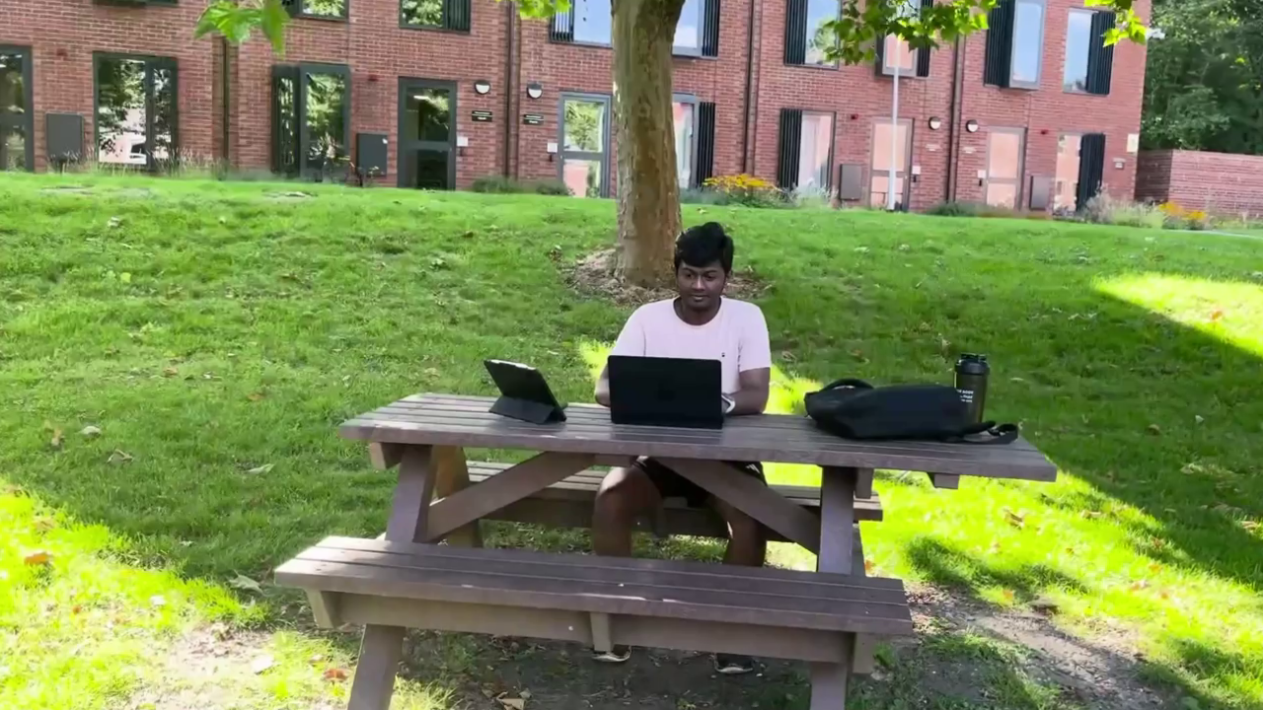

In [7]:
scene_info.train_cameras[40].image

In [8]:
p_img_35 = scene_info.train_cameras[35]
p_img_40 = scene_info.train_cameras[40] 


print(p_img_35, p_img_40)

CameraInfo(uid=1, R=array([[-0.90352109,  0.05520896,  0.42497248],
       [ 0.24532373,  0.87973477,  0.40728736],
       [-0.35137716,  0.47224856, -0.80840299]]), T=array([ 0.40767039, -0.43513901,  3.83764563]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7BEA8C11A1D0>, image_path='./data/custom/work/images/frame_00036.png', image_name='frame_00036', width=1263, height=710) CameraInfo(uid=1, R=array([[-0.82587396,  0.04125708,  0.56234336],
       [ 0.29539694,  0.88116175,  0.369181  ],
       [-0.48028413,  0.47101148, -0.73991576]]), T=array([ 0.32862453, -0.49113145,  3.79006896]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7BEA8C11A4D0>, image_path='./data/custom/work/images/frame_00041.png', image_name='frame_00041', width=1263, height=710)


In [9]:
def get_camera_matrix(width, height, fov_x, fov_y):
    fx = width / (2 * np.tan(fov_x / 2))
    fy = height / (2 * np.tan(fov_y / 2))
    cx = width / 2
    cy = height / 2
    return np.array([[fx, 0, cx],
                     [0, fy, cy],
                     [0,  0,  1]], dtype=np.float32)

In [10]:
# Loading Intrinsic  

fov_x = p_img_35.FovX
fov_y = p_img_35.FovY
width = p_img_35.width
height = p_img_35.height 

K = get_camera_matrix(width, height, fov_x, fov_y) 
print(K) 

# Loading Extrinsic 
R1 = p_img_35.R
T1 = p_img_35.T
R2 = p_img_40.R
T2 = p_img_40.T


[[1.1141053e+03 0.0000000e+00 6.3150000e+02]
 [0.0000000e+00 1.1088203e+03 3.5500000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]


In [11]:
import cv2

In [12]:
img_35 = Image.open(p_img_35.image_path)
img_40 = Image.open(p_img_40.image_path) 

gray_img_35 = img_35.convert('L')
gray_img_40 = img_40.convert('L')

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(np.array(gray_img_35), np.array(gray_img_40)) /16.0

u, v = 630, 355  # Example image coordinates

# Get the disparity value at this point
disparity_value = disparity[v, u]

# Calculate the baseline (distance between cameras)
baseline = np.linalg.norm(T1 - T2)

# Calculate depth (Z) using the disparity
depth = (K[0, 0] * baseline) / disparity_value

# Back-project to 3D coordinates
normalized_point = np.linalg.inv(K) @ np.array([u, v, 1])
world_point = normalized_point * depth

print("3D World Coordinates:", world_point)

hypothetical_R = R1
hypothetical_T = world_point

print("Hypothetical Camera Rotation Matrix:", hypothetical_R)
print("Hypothetical Camera Translation Vector:", hypothetical_T)

3D World Coordinates: [ 1.61884257e-01  1.74965474e-06 -1.20235358e+02]
Hypothetical Camera Rotation Matrix: [[-0.90352109  0.05520896  0.42497248]
 [ 0.24532373  0.87973477  0.40728736]
 [-0.35137716  0.47224856 -0.80840299]]
Hypothetical Camera Translation Vector: [ 1.61884257e-01  1.74965474e-06 -1.20235358e+02]


In [13]:
scene_info.test_cameras[0]

CameraInfo(uid=1, R=array([[ 0.54460935,  0.44722768, -0.70949846],
       [-0.33031972,  0.89196353,  0.30869069],
       [ 0.77090177,  0.06624549,  0.6334998 ]]), T=array([ 0.29249024, -0.32565342,  0.20013635]), FovY=0.6196963117792306, FovX=1.031333969603764, image=<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1263x710 at 0x7BEA8C7609D0>, image_path='./data/custom/work/images/frame_00171.png', image_name='frame_00171', width=1263, height=710)

In [1]:
import os
import random
import json
from utils.system_utils import searchForMaxIteration
from scene.dataset_readers import sceneLoadTypeCallbacks
from scene.gaussian_model import GaussianModel
from arguments import ModelParams
from utils.camera_utils import cameraList_from_camInfos, camera_to_JSON

class Scene:

    gaussians : GaussianModel

    def __init__(self, args : ModelParams, gaussians : GaussianModel, load_iteration=None, shuffle=True, resolution_scales=[1.0]):
        """b
        :param path: Path to colmap scene main folder.
        """
        self.model_path = args.model_path
        self.loaded_iter = None
        self.gaussians = gaussians

        if load_iteration:
            if load_iteration == -1:
                self.loaded_iter = searchForMaxIteration(os.path.join(self.model_path, "point_cloud"))
            else:
                self.loaded_iter = load_iteration
            print("Loading trained model at iteration {}".format(self.loaded_iter))

        self.train_cameras = {}
        self.test_cameras = {}

        
        if os.path.exists(os.path.join(args.source_path, "sparse")):
            
            scene_info = sceneLoadTypeCallbacks["Colmap"](args.source_path, args.images, args.eval)
        elif os.path.exists(os.path.join(args.source_path, "transforms_train.json")):
            print("Found transforms_train.json file, assuming Blender data set!")
            scene_info = sceneLoadTypeCallbacks["Blender"](args.source_path, args.white_background, args.eval)
        else:
            print(os.path.join(args.source_path, "sparse"))
            assert False, "Could not recognize scene type!"

        if not self.loaded_iter:
            with open(scene_info.ply_path, 'rb') as src_file, open(os.path.join(self.model_path, "input.ply") , 'wb') as dest_file:
                dest_file.write(src_file.read())
            json_cams = []
            camlist = []
            if scene_info.test_cameras:
                camlist.extend(scene_info.test_cameras)
            if scene_info.train_cameras:
                camlist.extend(scene_info.train_cameras)
            for id, cam in enumerate(camlist):
                json_cams.append(camera_to_JSON(id, cam))
            with open(os.path.join(self.model_path, "cameras.json"), 'w') as file:
                json.dump(json_cams, file)

        if shuffle:
            random.shuffle(scene_info.train_cameras)  # Multi-res consistent random shuffling
            random.shuffle(scene_info.test_cameras)  # Multi-res consistent random shuffling

        self.cameras_extent = scene_info.nerf_normalization["radius"]

        for resolution_scale in resolution_scales:
            print("Loading Training Cameras")
            self.train_cameras[resolution_scale] = cameraList_from_camInfos(scene_info.train_cameras, resolution_scale, args)
            print("Loading Test Cameras")
            self.test_cameras[resolution_scale] = cameraList_from_camInfos(scene_info.test_cameras, resolution_scale, args)

        if self.loaded_iter:
            self.gaussians.load_ply(os.path.join(self.model_path,
                                                           "point_cloud",
                                                           "iteration_" + str(self.loaded_iter),
                                                           "point_cloud.ply"))
        else:
            self.gaussians.create_from_pcd(scene_info.point_cloud, self.cameras_extent)

    def save(self, iteration):
        point_cloud_path = os.path.join(self.model_path, "point_cloud/iteration_{}".format(iteration))
        self.gaussians.save_ply(os.path.join(point_cloud_path, "point_cloud.ply"))

    def getTrainCameras(self, scale=1.0):
        ## yogi added
    
        # yogi added 
        return self.train_cameras[scale]

    def getTestCameras(self, scale=1.0):
        return self.test_cameras[scale]

In [ ]:
test = Scene()